# Special Case: Running Forest-Guided Clustering on Large Datasets

📚 In this tutorial, we demonstrate how to apply **Forest-Guided Clustering (FGC)** efficiently on **large datasets**. FGC relies on a **proximity matrix** derived from a trained Random Forest model. While this approach enables model-specific and insightful clustering, it can become **computationally demanding** as the number of samples increases. Several steps in the FGC pipeline may contribute to high **runtime** and **memory usage** when working with large data:

* Computing the proximity matrix (size N × N)
* Running bootstrapped Jaccard Index evaluations to determine clustering stability
* Repeated k-Medoids clustering, especially when optimizing the number of clusters

For example, if *k=None* (default), FGC will evaluate clustering stability for each *k* from 2 to 6 (5 values). With *JI_bootstrap_iter=30* bootstrap iterations, this leads to **155 K-Medoids runs** (5 without bootstrapping + 5 × 30 bootstrapped). Each run operates on the full N × N proximity matrix, which can quickly exhaust memory and CPU resources on large datasets. In this tutorial, we’ll walk through **practical strategies** to improve the runtime and scalability of FGC, so you can still uncover actionable patterns from large data:

* Parallelize operations
* Use a faster variant of the PAM algorithm
* Apply subsampling to reduce computational load 

📦 **Installation:** To get started, you need to install the `fgclustering` package. Please follow the instructions on the [official installation guide](https://forest-guided-clustering.readthedocs.io/en/latest/_getting_started/installation.html).

🚧 **Note:** For a general introduction to FGC, please refer to our [Introduction Notebook](https://forest-guided-clustering.readthedocs.io/en/latest/_tutorials/introduction_to_FGC_use_cases.html).

⚠️ **Note:** Total runtime depends on your system’s resources. Timing results shown here may vary slightly, but relative performance gains should remain consistent.

**Imports:**

In [1]:
## Import the Forest-Guided Clustering package
from fgclustering import (
    forest_guided_clustering, 
    forest_guided_feature_importance, 
    plot_forest_guided_feature_importance, 
    plot_forest_guided_decision_paths,
    DistanceRandomForestProximity,
    ClusteringKMedoids,
    ClusteringClara
)

## Imports for datasets
from sklearn.datasets import fetch_california_housing

## Additional imports for use-cases

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import pandas as pd
import timeit
import time

## 🏠 The California Housing Dataset

For this special case, we’ll once again use the **California Housing dataset**, which contains **20,640 samples**, a size large enough to noticeably impact the runtime of Forest-Guided Clustering (FGC). This makes it a suitable candidate for exploring how FGC scales and how we can improve its performance. This dataset was also used in *Use Case 3*, please refer there for a full description. To benchmark different runtime optimization strategies, we will train a **Random Forest model on the full dataset** and compare the runtime and memory usage across various configurations.

In [2]:
data_housing = fetch_california_housing(as_frame=True)
data_housing = data_housing.frame
data_housing.rename(columns={'MedHouseVal':'target'}, inplace=True)

X_housing = data_housing.loc[:, data_housing.columns != 'target']
y_housing = data_housing.target

print(f"Traing model for {X_housing.shape[0]} house blocks.")

Traing model for 20640 house blocks.


In [3]:
regressor = RandomForestRegressor(random_state=42)
grid = {'max_depth':[2, 5, 10], 'max_features': ['log2'], 'n_estimators': [100], 'bootstrap': [True], 'oob_score': [True]}
grid_search_cv = GridSearchCV(regressor, grid, cv=5, return_train_score=True)
grid_search_cv.fit(X_housing, y_housing)
results = pd.DataFrame(grid_search_cv.cv_results_)

model = grid_search_cv.best_estimator_
print(f'OOB R^2 of prediction model: {model.oob_score_}')

OOB R^2 of prediction model: 0.7874297729402784


## Benchmarking FGC Runtime on Large Datasets

To ensure that the runtime comparison remains manageable, we will use only the first 10,000 samples of the dataset. This subset is still large enough to demonstrate the impact of various performance optimization strategies, while keeping execution times reasonable.

In [4]:
X_housing_subset = X_housing.iloc[:10000].reset_index(drop=True)
y_housing_subet = y_housing.iloc[:10000].reset_index(drop=True)

### ⏱️ Baseline Runtime

To evaluate how Forest-Guided Clustering (FGC) performs on large datasets, we first define a baseline configuration. This will serve as the reference point for evaluating performance improvements.

In [5]:
clustering_strategy = ClusteringKMedoids(method="pam")
n_jobs = 1

start = time.perf_counter()
fgc = forest_guided_clustering(
    estimator=model, 
    X=X_housing_subset, 
    y=y_housing_subet, 
    clustering_distance_metric=DistanceRandomForestProximity(),
    clustering_strategy=clustering_strategy, 
    n_jobs=n_jobs, 
)
end = time.perf_counter()

minutes = (end - start)
print(f"Baseline Runtime: ⏱️ {minutes:.2f} seconds")

Using a sample size of 10.0 % of the input data.
Using range k = (2, 6) to optimize k.


Optimizing k: 100%|██████████| 5/5 [01:04<00:00, 12.91s/it]


Optimal number of clusters k = 2

Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                                                  Cluster_JI
 2 0.943844    True    0.639                                        {1: 0.495, 2: 0.782}
 3      NaN   False    0.545                                {1: 0.542, 2: 0.6, 3: 0.494}
 4      NaN   False    0.459                     {1: 0.424, 2: 0.507, 3: 0.47, 4: 0.436}
 5      NaN   False    0.561          {1: 0.545, 2: 0.532, 3: 0.642, 4: 0.485, 5: 0.599}
 6      NaN   False    0.518 {1: 0.458, 2: 0.377, 3: 0.572, 4: 0.565, 5: 0.54, 6: 0.598}
Baseline Runtime: ⏱️ 64.65 seconds


### 🔀 Parallelizing Bootstrap Evaluation

FGC calculates the **Jaccard Index** over multiple bootstrapped subsets, which can be computationally intensive. You can **parallelize** this process using the `n_jobs` parameter:

* `n_jobs=1`: default, no parallelism
* `n_jobs=-1`: use all available CPU cores
* `n_jobs=n`: use *n* parallel workers

We now re-run FGC with `n_jobs=5`, enabling concurrent execution of the Jaccard bootstrap process.

In [6]:
clustering_strategy = ClusteringKMedoids(method="pam")
n_jobs = 5

start = time.perf_counter()
fgc = forest_guided_clustering(
    estimator=model, 
    X=X_housing_subset, 
    y=y_housing_subet, 
    clustering_distance_metric=DistanceRandomForestProximity(),
    clustering_strategy=clustering_strategy, 
    n_jobs=n_jobs, 
)
end = time.perf_counter()

minutes = (end - start)
print(f"Runtime: ⏱️ {minutes:.2f} seconds")

Using a sample size of 10.0 % of the input data.
Using range k = (2, 6) to optimize k.


Optimizing k: 100%|██████████| 5/5 [00:52<00:00, 10.57s/it]


Optimal number of clusters k = 2

Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                                                  Cluster_JI
 2 0.943844    True    0.639                                        {1: 0.495, 2: 0.782}
 3      NaN   False    0.545                                {1: 0.542, 2: 0.6, 3: 0.494}
 4      NaN   False    0.459                     {1: 0.424, 2: 0.507, 3: 0.47, 4: 0.436}
 5      NaN   False    0.561          {1: 0.545, 2: 0.532, 3: 0.642, 4: 0.485, 5: 0.599}
 6      NaN   False    0.518 {1: 0.458, 2: 0.377, 3: 0.572, 4: 0.565, 5: 0.54, 6: 0.598}
Runtime: ⏱️ 52.91 seconds


By parallelizing the bootstrap phase, we already observe a noticeable speedup.

### ⚡ Speeding Up Clustering

FGC uses [**K-Medoids**](https://python-kmedoids.readthedocs.io/en/latest/) to cluster the proximity matrix. By default, it uses the classic **PAM (Partitioning Around Medoids)** algorithm, which is accurate but computationally expensive. The `fasterpam` algorithm is an optimized variant that reduces redundant distance calculations and improves convergence speed while maintaining clustering quality. You can activate it in FGC by setting: `ClusteringKMedoids(method="fasterpam")`.

In [7]:
clustering_strategy = ClusteringKMedoids(method="fasterpam")
n_jobs = 1

start = time.perf_counter()
fgc = forest_guided_clustering(
    estimator=model, 
    X=X_housing_subset, 
    y=y_housing_subet, 
    clustering_distance_metric=DistanceRandomForestProximity(),
    clustering_strategy=clustering_strategy, 
    n_jobs=n_jobs, 
)
end = time.perf_counter()

minutes = (end - start)
print(f"Runtime: ⏱️ {minutes:.2f} seconds")

Using a sample size of 10.0 % of the input data.
Using range k = (2, 6) to optimize k.


Optimizing k: 100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


Clustering Evaluation Summary:
 k Score  Stable  Mean_JI                                                   Cluster_JI
 2  None   False    0.497                                          {1: 0.66, 2: 0.333}
 3  None   False    0.460                               {1: 0.556, 2: 0.356, 3: 0.469}
 4  None   False    0.568                     {1: 0.666, 2: 0.514, 3: 0.516, 4: 0.577}
 5  None   False    0.541              {1: 0.517, 2: 0.45, 3: 0.628, 4: 0.5, 5: 0.609}
 6  None   False    0.504 {1: 0.426, 2: 0.613, 3: 0.383, 4: 0.536, 5: 0.528, 6: 0.537}
Runtime: ⏱️ 21.57 seconds



/Users/lisasousa/Desktop/fg-clustering/fgclustering/optimizer.py:118: UserWarning: No stable clusters were found for JI cutoff 0.6!
  warnings.warn(f"No stable clusters were found for JI cutoff {JI_discart_value}!")


This small change leads to substantial gains in clustering speed, especially when repeated across many bootstrap iterations.

### 🥇 Combining Both Strategies

The best performance is achieved when we combine both techniques:

* Set `n_jobs > 1` to parallelize bootstrap computation
* Set `method_clustering="fasterpam"` to accelerate clustering

In [8]:
clustering_strategy = ClusteringKMedoids(method="fasterpam")
n_jobs = 5

start = time.perf_counter()
fgc = forest_guided_clustering(
    estimator=model, 
    X=X_housing_subset, 
    y=y_housing_subet, 
    clustering_distance_metric=DistanceRandomForestProximity(),
    clustering_strategy=clustering_strategy, 
    n_jobs=n_jobs, 
)
end = time.perf_counter()

minutes = (end - start) 
print(f"Baseline Runtime: ⏱️ {minutes:.2f} seconds")

Using a sample size of 10.0 % of the input data.
Using range k = (2, 6) to optimize k.


Optimizing k: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


Clustering Evaluation Summary:
 k Score  Stable  Mean_JI                                                   Cluster_JI
 2  None   False    0.490                                         {1: 0.656, 2: 0.324}
 3  None   False    0.460                               {1: 0.556, 2: 0.356, 3: 0.469}
 4  None   False    0.568                     {1: 0.666, 2: 0.514, 3: 0.516, 4: 0.577}
 5  None   False    0.541              {1: 0.517, 2: 0.45, 3: 0.628, 4: 0.5, 5: 0.609}
 6  None   False    0.504 {1: 0.426, 2: 0.613, 3: 0.382, 4: 0.536, 5: 0.528, 6: 0.537}
Baseline Runtime: ⏱️ 17.55 seconds



/Users/lisasousa/Desktop/fg-clustering/fgclustering/optimizer.py:118: UserWarning: No stable clusters were found for JI cutoff 0.6!
  warnings.warn(f"No stable clusters were found for JI cutoff {JI_discart_value}!")


This combined strategy significantly reduces FGC’s runtime—often by a factor of 2–5, depending on hardware, and scales even better on larger datasets.

### 📋 Summary

| Strategy                           | Avg. Runtime |
| ---------------------------------- | ------------ |
| Baseline                           | 65 sec      |
| Parallelizing Bootstrap Evaluation | 53 sec       |
| Speeding Up Clustering             | 22 sec      |
| Both combined                      | 18 sec       |

These runtime reductions make FGC practical even for larger datasets, without compromising its ability to generate insightful explanations.

## Clustering at Scale: Strategies for Large Datasets

If the previously mentioned performance enhancements (e.g. parallelization or faster K-Medoids) are still not sufficient, perhaps due to very large datasets or limited computational resources, then the **memory-efficient proximity matrix** and **subsampling** becomes a practical solution. 



### 💾 Memory-Efficient Proximity Matrix

When working with large datasets like the California Housing dataset (20,640 samples), the proximity matrix becomes very large—specifically, **20,640 × 20,640**, which translates to about **3.4 GB of memory** if stored as *float32*. To avoid memory bottlenecks or system swapping, we enable FGC's memory-efficient mode:

* `memory_efficient=True`: stores the proximity matrix on disk rather than in RAM
* `output_dir`: directory where the matrix is saved

Internally, *np.memmap* is used, a NumPy feature that enables reading/writing parts of large arrays from disk without loading the entire matrix into memory. This is especially useful for large-scale computations, as it prevents RAM overload and allows for seamless streaming access. This memory-efficient mode is highly recommended for datasets with more than \~10,000 samples.

In [9]:
clustering_distance_metric = DistanceRandomForestProximity(memory_efficient=True, dir_distance_matrix="./")

### 🔁 Clustering Large Applications

One effective approach for this is the **CLARA algorithm** (Clustering Large Applications). CLARA works by applying K-Medoids clustering not on the full dataset but on multiple small, randomly selected subsamples. For each subsample, it performs clustering and then evaluates the resulting medoids across the entire dataset. The configuration that minimizes the overall clustering cost is selected as the best. This method allows us to find a representative clustering structure without computing the full distance matrix or running K-Medoids over the entire dataset.

> 💡 While CLARA trades off some precision for performance, it often yields a very good approximation of the optimal clustering in a fraction of the time and memory.

We’ll now apply CLARA-based clustering on the **California Housing dataset** used earlier. This lets us benchmark performance and evaluate clustering quality when using subsampling instead of full-matrix proximity calculations.

⚠️ **Note:** The choice of `sub_sample_size` and `sampling_iter` is crucial. If the subsample size is too small or the number of iterations too low, CLARA might miss relevant patterns in the data. A good rule of thumb is to use a **moderate fraction of the full dataset** for subsampling (e.g. 10-60%, depending on the JI bootstrap size) and **enough iterations** (e.g. 5–20) to ensure robustness and reproducibility of the results.


In [10]:
clustering_distance_metric = DistanceRandomForestProximity(memory_efficient=True, dir_distance_matrix="./")
clustering_strategy = ClusteringClara(sub_sample_size=0.6, sampling_iter=5, method="fasterpam")
JI_bootstrap_iter = 50
JI_bootstrap_sample_size = 1.0
n_jobs = 5

start = time.perf_counter()
fgc = forest_guided_clustering(
    estimator=model, 
    X=X_housing, 
    y=y_housing, 
    clustering_distance_metric=clustering_distance_metric, 
    clustering_strategy=clustering_strategy, 
    JI_bootstrap_sample_size=JI_bootstrap_sample_size, 
    JI_bootstrap_iter=JI_bootstrap_iter,
    n_jobs=n_jobs, 
)
end = time.perf_counter()

minutes = (end - start) / 60
print(f"Runtime: ⏱️ {minutes:.2f} minutes")

Using range k = (2, 6) to optimize k.


Optimizing k: 100%|██████████| 5/5 [39:51<00:00, 478.27s/it]


Optimal number of clusters k = 6

Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                                                  Cluster_JI
 2 0.999268    True    0.736                                        {1: 0.836, 2: 0.637}
 3 0.766273    True    0.614                                {1: 0.611, 2: 0.64, 3: 0.59}
 4 0.923951    True    0.645                    {1: 0.624, 2: 0.637, 3: 0.583, 4: 0.735}
 5 0.771415    True    0.645          {1: 0.619, 2: 0.637, 3: 0.749, 4: 0.588, 5: 0.634}
 6 0.761300    True    0.745 {1: 0.645, 2: 0.745, 3: 0.78, 4: 0.866, 5: 0.768, 6: 0.666}
Runtime: ⏱️ 39.86 minutes


100%|██████████| 8/8 [00:00<00:00, 60.56it/s]


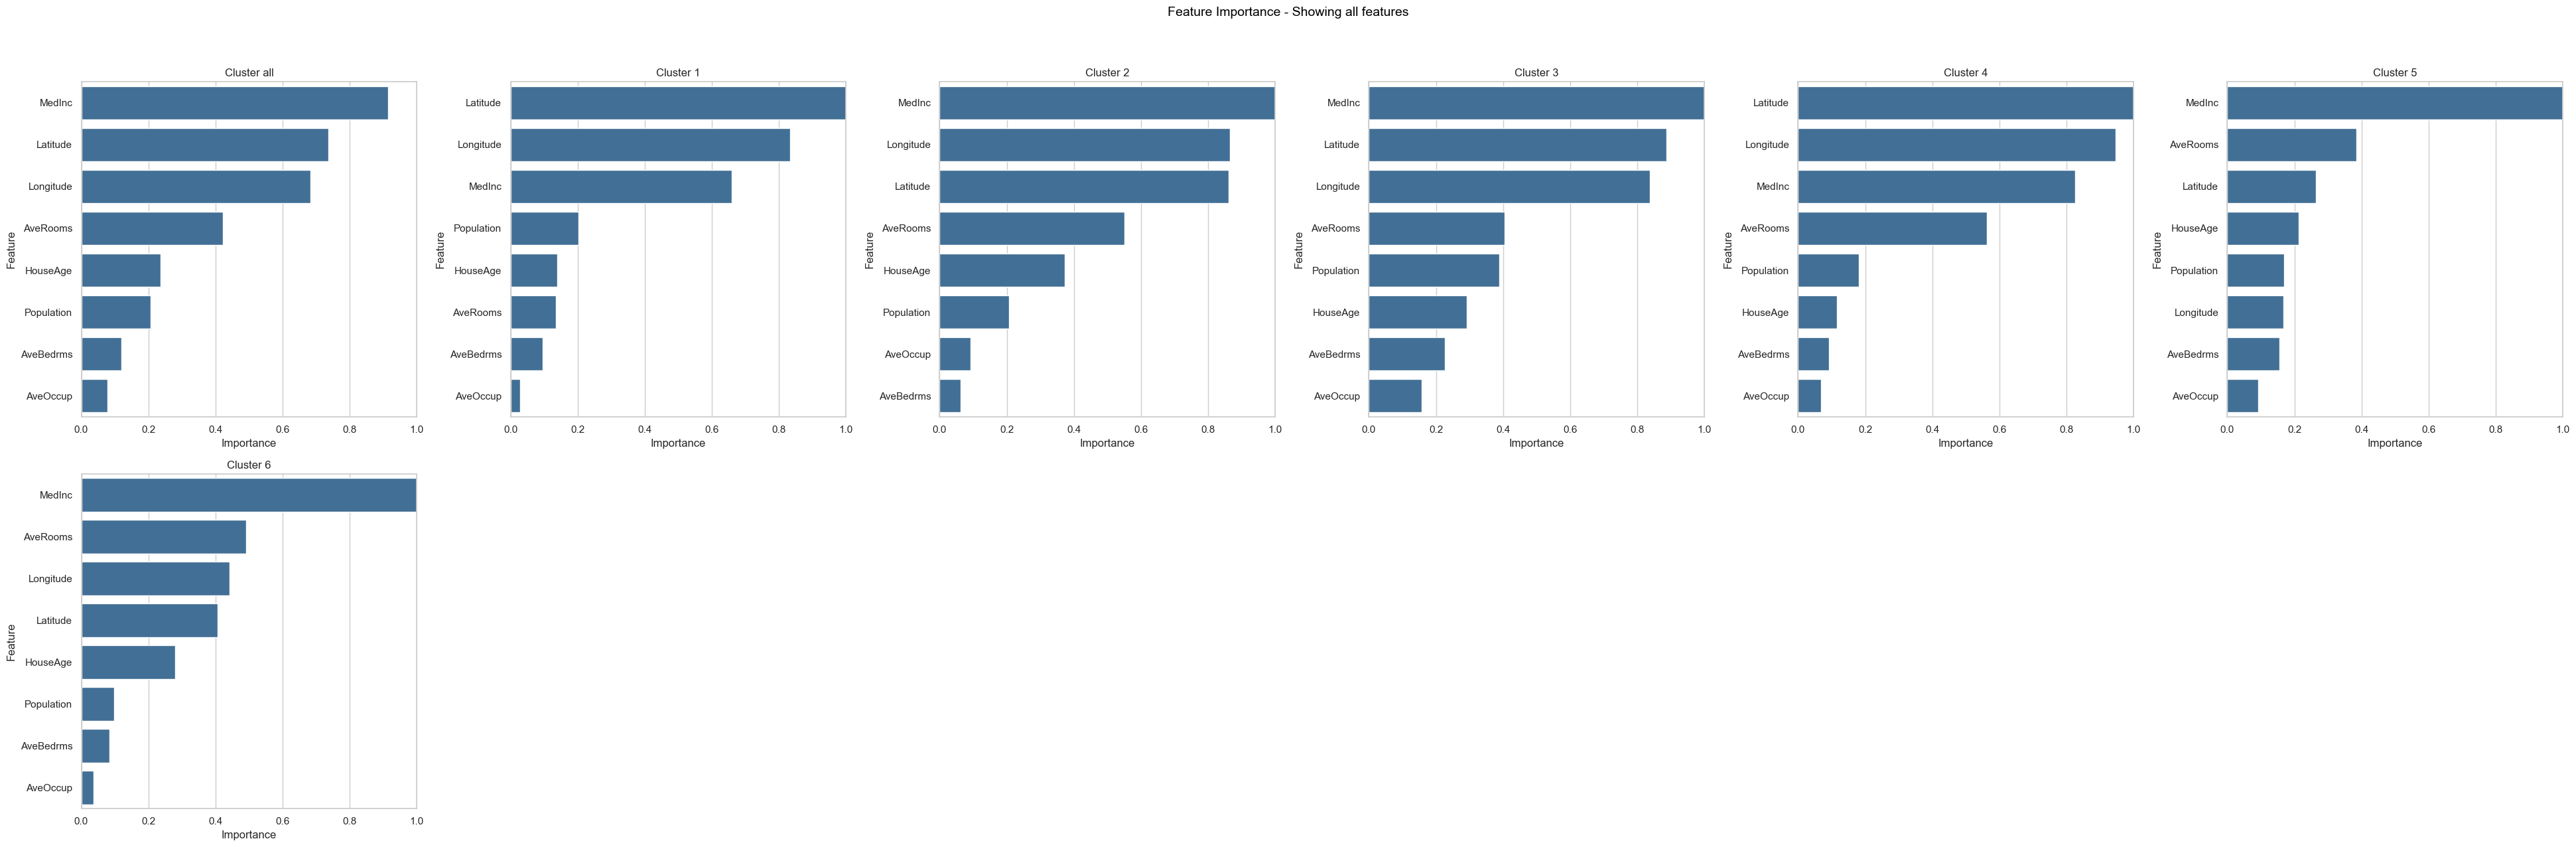

In [11]:
feature_importance = forest_guided_feature_importance(
    X=X_housing, 
    y=y_housing, 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
    feature_importance_distance_metric="wasserstein",
)

plot_forest_guided_feature_importance(
    feature_importance_local=feature_importance.feature_importance_local,
    feature_importance_global=feature_importance.feature_importance_global,
    num_cols=6,
)

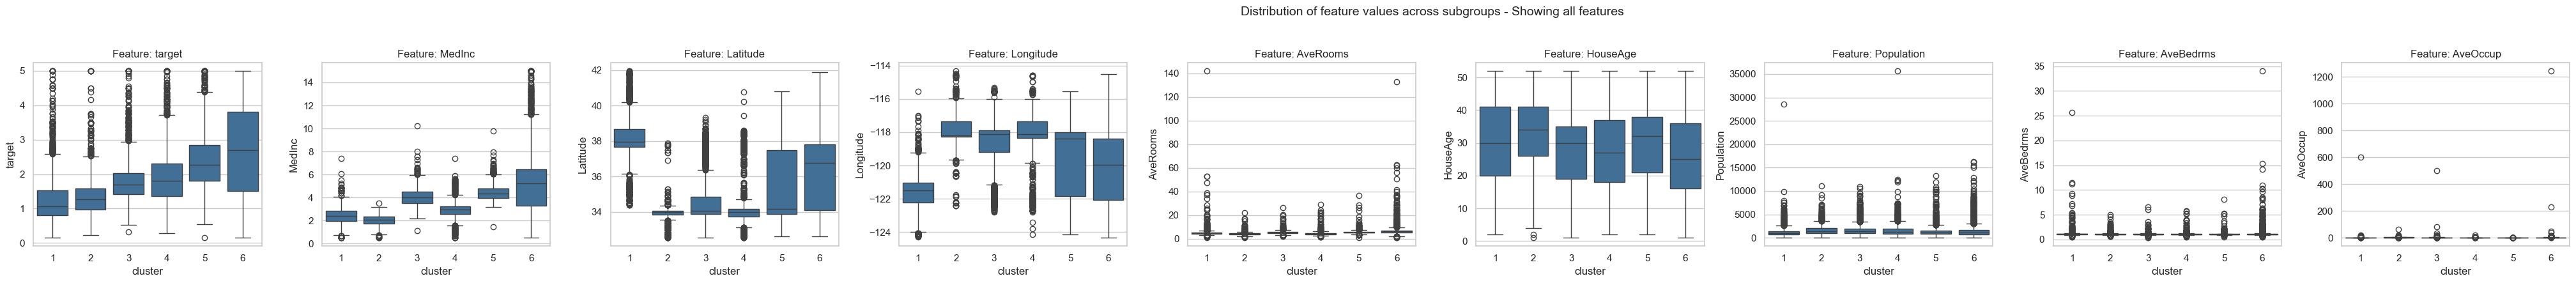

In [12]:
plot_forest_guided_decision_paths(
    data_clustering=feature_importance.data_clustering,
    model_type=fgc.model_type,
    heatmap=False,
    num_cols=10
)

As we can see above, using the **CLARA** algorithm does not necessarily reduce runtime, but it makes FGC feasible on **very large datasets**, where even memory-efficient techniques like storing the distance matrix on disk become impractical. For instance, a full proximity matrix for 200,000 samples would require  roughly **160 GB of memory** if stored as 4-byte *float32* values. This far exceeds the RAM capacity of most machines and could also strain disk I/O when using memory mapping.

In conclusion, CLARA offers a robust workaround by working on smaller, representative subsamples, allowing FGC to scale to massive datasets. While runtime gains may vary, its real strength lies in making interpretation possible when traditional distance-based clustering would otherwise be infeasible.